## 2 Ridge Regression
### Student ID: 35224436 | Full name: Yiming Zhang

## Task I.  SGD Weight Update Derivation

#### 1. Error function definition

$$
\begin{align*}
E(\mathbf{w}) &= \frac{1}{2n} \sum_{n=1}^N (t_n - y(\mathbf{x_n}, \mathbf{w}))^2 \\
&= \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2
\end{align*}
$$

#### 2. L2 regularization term
$$
\frac{\lambda}{2} \|\mathbf{w}\|^2
$$

#### 3. The final error function

$$
\begin{align*}E(\mathbf{w}) = \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2
\end{align*} + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

#### 4. Gradient Computation

To use gradient descent, we need to compute the gradient of the error function with respect to the weight vector $\mathbf{w}$:

$$
\nabla_{\mathbf{w}} E(\mathbf{w}) = \frac{\partial E(\mathbf{w})}{\partial \mathbf{w}}
$$

Computing the gradients of the error term and regularization term separately:

**Gradient of the error term:**
$$
\frac{\partial}{\partial \mathbf{w}} 
\left[
    \frac{1}{2n} \|\mathbf{t} - \boldsymbol{\Phi}\mathbf{w} \|^2
\right] = 
\frac{\partial}{\partial \mathbf{w}} 
\left[
\frac{1}{2n}​(\mathbf{t} - \boldsymbol{\Phi}\mathbf{w})^⊤(\mathbf{t}-\boldsymbol{\Phi}\mathbf{w})
\right] = 
\frac{1}{n}\boldsymbol{\Phi}^T(\boldsymbol{\Phi}\mathbf{w} - \mathbf{t})
$$

**Gradient of the regularization term:**
$$
\frac{\partial}{\partial \mathbf{w}} \left[\frac{\lambda}{2}\|\mathbf{w}\|^2\right] = \frac{\lambda}{2} \cdot 2\mathbf{w} = \lambda\mathbf{w}
$$

**Total gradient:**
$$
\nabla_{\mathbf{w}} E(\mathbf{w}) = \frac{1}{n}\boldsymbol{\Phi}^T(\boldsymbol{\Phi}\mathbf{w} - \mathbf{t}) + \lambda\mathbf{w}
$$

#### 5. Normal equations

Set the gradient to zero
$$
\frac{1}{n}\boldsymbol{\Phi}^T(\boldsymbol{\Phi}\mathbf{w} - \mathbf{t}) + \lambda\mathbf{w} = 0 \\
(\boldsymbol{\Phi}^T\boldsymbol{\Phi} + {n}\lambda{I})\mathbf{w} = \boldsymbol{\Phi}^T\mathbf{t}
$$
The **normal equation** is
$$
\mathbf{w} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi} + {n}\lambda{I})^{-1}\boldsymbol{\Phi}^T\mathbf{t}
$$

#### 6. SGD update
Set mini-batch size is $\mathbf{b}$
$$
\mathbf{w}_{\tau} = \mathbf{w}_{\tau-1} - \eta \nabla_{\mathbf{w}_{\tau-1}} E(\mathbf{w}_{\tau-1})
$$
$$
= \mathbf{w}_{\tau-1} - \eta 
\left[
\frac{1}{b}\tilde{\boldsymbol{\Phi}_{\tau}^T}(\tilde{\boldsymbol{\Phi}_{\tau}}\mathbf{w}_{\tau-1} - \tilde{\mathbf{t}_{\tau}}) + \lambda\mathbf{w}_{\tau-1}
\right]
$$




## Task II. SGD Implementation

In [29]:
import numpy as np


class SGDRidgeRegressor:
    def __init__(
        self,
        batch_size=1,
        eta=0.01,
        tau_max=100,
        epsilon=0.00001,
        random_state=None,
        lam=1,
    ):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        self.lam = lam

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        # x = np.asarray(x, dtype=float)
        # y = np.asarray(y, dtype=float).reshape(-1)
        n, p = x.shape

        self.w_ = np.zeros(shape=(self.tau_max + 1, p))

        for tau in range(1, self.tau_max + 1):
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            # Xb, yb = x[idx], y[idx]

            resid = x[idx].dot(self.w_[tau - 1].ravel()) - y[idx].ravel()  # residual
            grad_data = x[idx].T.dot(resid) / self.batch_size
            reg_grad = self.lam * self.w_[tau - 1]
            reg_grad[0] = 0
            grad = grad_data + reg_grad

            self.w_[tau] = (self.w_[tau - 1] - self.eta * grad).ravel()
            if np.linalg.norm(self.w_[tau] - self.w_[tau - 1]) < self.epsilon:
                break

        self.coef_ = self.w_[tau]
        self.w_ = self.w_[: tau + 1]
        return self

    def predict(self, x):
        x = np.asarray(x, dtype=float)
        return x @ self.coef_

## Task III: L2 Regularization Effect Analysis

### Step 1: Synthetic data construction

Dataset is generated according to the following specifications.

- $X \sim \text{Uniform}(-0.6, 0.6)$
- $Y = \frac{\sin(2\pi x)}{2 + 3x} + \epsilon$
- $\epsilon \sim N(0, 0.1)$



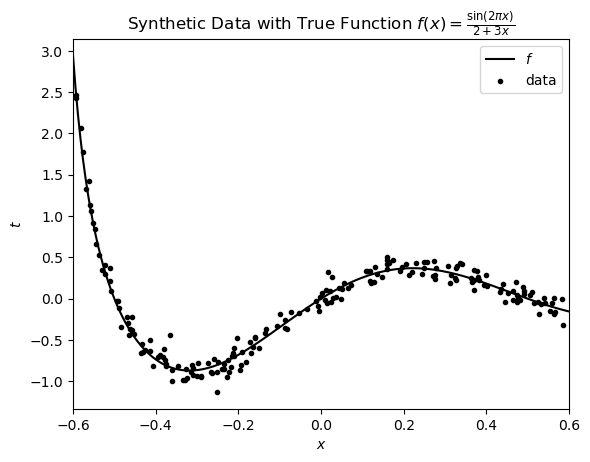

In [30]:
import numpy as np
import matplotlib.pyplot as plt


def sample_data(n, seed=None):
    if seed is not None:
        np.random.seed(seed)

    X = np.random.uniform(-0.6, 0.6, size=n)
    f = np.sin(2 * np.pi * X) / (2 + 3 * X)
    eps = np.random.normal(0.0, 0.1, size=n)
    y = f + eps
    return X.reshape(-1, 1), y


# true function
def f(x):
    x = np.asarray(x)
    return np.sin(2 * np.pi * x) / (2 + 3 * x)


# generation function
def make_additive_noise_data(n, f, a, b, noise=0.1, random_state=None):
    RNG = np.random.default_rng(random_state)
    x = RNG.uniform(a, b, size=(n, 1))
    y = f(x) + RNG.normal(0, noise, size=(n, 1))
    return x, y


# Visualization function following Activity 2.3 style
def plot_function(f, a, b, models=[], data=None, ax=None, ax_labels=True, legend=True):
    ax = plt.gca() if ax is None else ax
    xx = np.linspace(a, b, 200).reshape(-1, 1)
    if len(models) == 1:
        ax.fill_between(
            xx.squeeze(), f(xx).squeeze(), models[0].predict(xx).squeeze(), alpha=0.3
        )
        ax.plot(xx, models[0].predict(xx), label="$y$")
    if len(models) > 1:
        for model in models:
            ax.plot(xx, model.predict(xx), color="gray", alpha=0.5)
    ax.plot(xx, f(xx), color="black", label="$f$")
    if data is not None:
        x, y = data
        ax.scatter(x, y, marker=".", color="black", label="data")
    if ax_labels:
        ax.set_xlabel("$x$")
        ax.set_ylabel("$t$")
    if legend:
        ax.legend()
    ax.margins(x=0)


# Visualize the data and true function
plot_function(
    f, -0.6, 0.6, data=sample_data(200, seed=42)
)
plt.title("Synthetic Data with True Function $f(x) = \\frac{\\sin(2\\pi x)}{2+3x}$")
plt.show()

### Step 2: Ridge Regression Training and Regularization Analysis
In this step, we train ridge regression models with different regularization parameters (λ) and analyze their effects on model performance and weight norms.

In [ ]:
from sklearn.metrics import mean_squared_error


class PolynomialFeatures:

    def __init__(self, degree):
        self.degree = degree

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        output = []
        for i in range(0, self.degree + 1):
            output.append(x**i)
        return np.column_stack(output)

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x, y)


def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


poly_features = PolynomialFeatures(degree=4)
# generate lambda values
lambda_values = np.geomspace(10**-10, 0.1, 101, endpoint=True)

print(f"Lambda range: {lambda_values[0]:.2e} to {lambda_values[-1]:.2e}")
print(f"Number of lambda values: {len(lambda_values)}")

# set the number of training repeats
n_repeats = 10

# variables to store the results of all repeats
all_train_errors = np.zeros((n_repeats, len(lambda_values)))
all_test_errors = np.zeros((n_repeats, len(lambda_values)))
# generate the test data
X_test, y_test = make_additive_noise_data(5000, f, -0.6, 0.6, random_state=15)
X_test_poly = poly_features.fit_transform(X_test)

print("\nTraining starts...")

for repeat in range(n_repeats):
    # generate the training data
    X_train, y_train = make_additive_noise_data(
        20, f, -0.6, 0.6, random_state=15 + repeat
    )
    # transform the training and test data
    X_train_poly = poly_features.transform(X_train)

    for i, lam in enumerate(lambda_values):
        # create and train the ridge regression model
        model = SGDRidgeRegressor(
            lam=lam, eta=0.01, tau_max=1000, epsilon=1e-6, random_state=15 - repeat
        )

        model.fit(X_train_poly, y_train)
        # predict
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)
        # calculate the error
        train_mse = mse(y_train, y_train_pred)
        test_mse = mse(y_test, y_test_pred)
        # store the results
        all_train_errors[repeat, i] = train_mse
        all_test_errors[repeat, i] = test_mse

        if i == len(lambda_values) - 1:
            print(
                f"Training {repeat+1}/{n_repeats}, Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}"
            )

print("\nTraining completed!")

# calculate the mean and standard deviation of the results
mean_train_errors = all_train_errors.mean(axis=0)
mean_test_errors = all_test_errors.mean(axis=0)

Lambda range: 1.00e-10 to 1.00e-01
Number of lambda values: 101

Training starts...
Training 1/10, Train MSE = 0.3492, Test MSE = 0.3356
Training 2/10, Train MSE = 0.3195, Test MSE = 0.3261
Training 3/10, Train MSE = 0.7128, Test MSE = 0.3391
Training 4/10, Train MSE = 0.2402, Test MSE = 0.3349
Training 5/10, Train MSE = 0.1616, Test MSE = 0.3435
Training 6/10, Train MSE = 0.5344, Test MSE = 0.3282
Training 7/10, Train MSE = 0.2122, Test MSE = 0.3483
Training 8/10, Train MSE = 0.2335, Test MSE = 0.3290
Training 9/10, Train MSE = 0.2282, Test MSE = 0.3547
Training 10/10, Train MSE = 0.2599, Test MSE = 0.3252

Training completed!


### Step 3: Results Visualization
Plotting the results to illustrate the effect of different λ values on model performance.

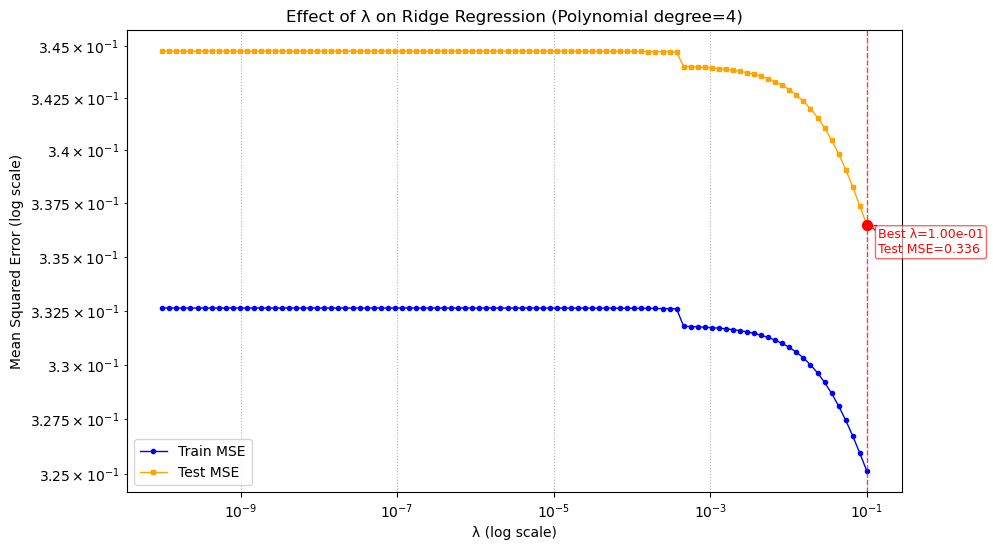

In [35]:
import matplotlib.pyplot as plt

# ===== Plot: MSE vs lambda =====
plt.figure(figsize=(10, 6))

plt.plot(
    lambda_values,
    mean_train_errors,
    label="Train MSE",
    color="blue",
    marker="o",
    markersize=3,
    linewidth=1,
)


plt.plot(
    lambda_values,
    mean_test_errors,
    label="Test MSE",
    color="orange",
    marker="s",
    markersize=3,
    linewidth=1,
)


plt.xscale("log")
plt.yscale("log")

plt.xlabel("λ (log scale)")
plt.ylabel("Mean Squared Error (log scale)")
plt.title("Effect of λ on Ridge Regression (Polynomial degree=4)")

# find best lambda based on minimal test MSE
best_idx = int(np.argmin(mean_test_errors))
best_lambda = float(lambda_values[best_idx])
best_test_mse = float(mean_test_errors[best_idx])

# mark the best point
plt.scatter(best_lambda, best_test_mse, color="red", s=50, zorder=5)
plt.axvline(best_lambda, color="red", linestyle="--", linewidth=1, alpha=0.7)
plt.annotate(
    f"Best λ={best_lambda:.2e}\nTest MSE={best_test_mse:.3g}",
    xy=(best_lambda, best_test_mse),
    xytext=(8, -20),
    textcoords="offset points",
    color="red",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.6),
    arrowprops=dict(arrowstyle="->", color="red", lw=1),
)

plt.legend()
plt.grid(True, linestyle=":")
plt.show()

### Step 4: Analysis

By analyzing this plot, we can observe that the regularization parameter $\mathbf{𝜆}$ controls the model’s complexity,thereby influencing underfitting and overfitting behaviors.

On the left side where $\mathbf{𝜆}$ is small, the training MSE (blue line) remains consistently lower than the test MSE (orange line). In this case, the model exhibits high variance and low bias, indicating an overfitting state. This phenomenon shows that the model is more inclined to memorize the training data rather than learn generalizable patterns.

As $\mathbf{𝜆}$ increases, in the rightmost third of the plot, we can observe that both the training MSE and test MSE decrease rapidly. This suggests that the model has learned sufficiently from the data and is successfully capturing the underlying patterns.

At $\mathbf{𝜆} = 10^{-1}$, the test MSE reaches its minimum value. At this point, bias and variance are balanced, and the model achieves its best generalization performance.

## Task IV

Imagine you have a dataset with highly correlated features. Would Ridge Regression or Lasso
be more appropriate? Why? How would your answer change if interpretability is the top
priority?

Answer:

For datasets with highly correlated features, **Ridge Regression would be better**. This is because Ridge Regression can distribute weights more evenly among the correlated features, which means the regression coefficients are spread out. This allows each feature to contribute to the prediction, making the model more stable. In contrast, Lasso tends to choose one feature and give it a large weight, while making other features' contributions close to zero. This strategy can be very unstable when the training data is small or when the test set has a different distribution.

However, if we look at this from an **interpretability perspective**, **Lasso is more suitable**. The reason is that Lasso automatically selects the important features and reduces the complexity of the model, making it easier for humans to understand.